# First: I need to prepare my data
# USE ONLY TRAIN DATA!!!

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pmdarima import auto_arima
from pmdarima.arima import ARIMA

from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.metrics import smape
from statistics import mean, median

In [2]:
time_series = pd.read_csv("selected_columns.csv", index_col=0, parse_dates=True)

In [3]:
time_series.head()

,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual
date,,,
2015-01-01 08:00:00,64277.0,385.0,1936.0
2015-01-01 09:00:00,65100.0,1053.0,1927.0
2015-01-01 10:00:00,65875.0,1635.0,1846.0
2015-01-01 11:00:00,67460.0,1883.0,1768.0
2015-01-01 12:00:00,65706.0,1857.0,1715.0


In [4]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50391 entries, 2015-01-01 08:00:00 to 2020-09-30 22:00:00
Data columns (total 3 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   FR_load_actual_entsoe_transparency  50391 non-null  float64
 1   FR_solar_generation_actual          50391 non-null  float64
 2   FR_wind_onshore_generation_actual   50391 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


In [5]:
time_series.iloc[-1000:]

,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual
date,,,
2020-08-20 07:00:00,45701.0,2793.0,2036.0
2020-08-20 08:00:00,47345.0,4267.0,2344.0
2020-08-20 09:00:00,48706.0,5323.0,2842.0
2020-08-20 10:00:00,50352.0,5855.0,3182.0
2020-08-20 11:00:00,49529.0,6145.0,3316.0
...,...,...,...
2020-09-30 18:00:00,51975.0,140.0,3185.0
2020-09-30 19:00:00,48210.0,142.0,3632.0
2020-09-30 20:00:00,48210.0,142.0,3965.0


In [105]:
small_ts = time_series.iloc[-100:]#['FR_load_actual_entsoe_transparency']
small_ts

,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,Day,Year,Month,DayOfWeek,HourOfDay
date,,,,,,,,
2020-09-26 19:00:00,43953.0,140.0,7673.0,26,2020,9,5,19
2020-09-26 20:00:00,44468.0,142.0,7424.0,26,2020,9,5,20
2020-09-26 21:00:00,45597.0,142.0,7515.0,26,2020,9,5,21
2020-09-26 22:00:00,43017.0,139.0,7580.0,26,2020,9,5,22
2020-09-26 23:00:00,40352.0,137.0,7983.0,26,2020,9,5,23
...,...,...,...,...,...,...,...,...
2020-09-30 18:00:00,51975.0,140.0,3185.0,30,2020,9,2,18
2020-09-30 19:00:00,48210.0,142.0,3632.0,30,2020,9,2,19
2020-09-30 20:00:00,48210.0,142.0,3965.0,30,2020,9,2,20


In [ ]:
# Extract year and month from the index
time_series.loc[:, 'Day'] = time_series.index.year
time_series.loc[:, 'Year'] = time_series.index.year
time_series.loc[:, 'Month'] = time_series.index.month
time_series['HourOfDay'] = time_series.index.hour

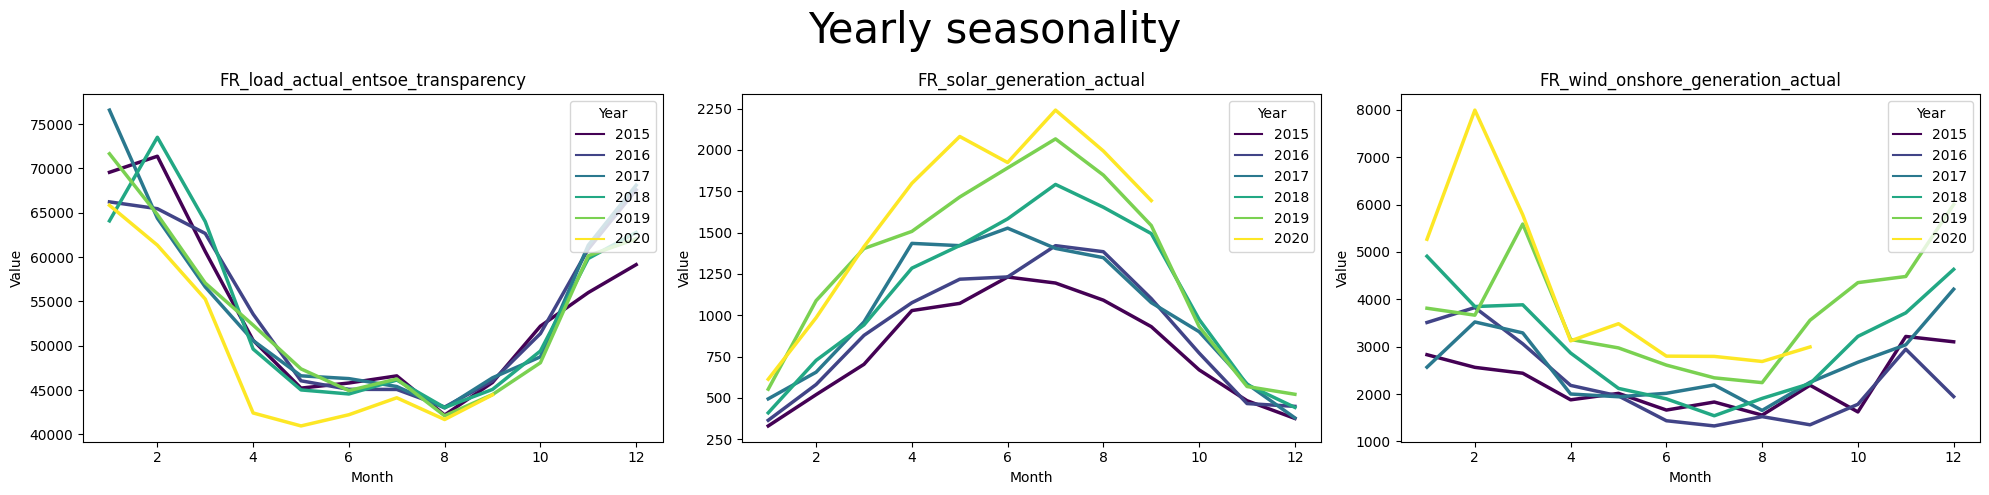

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_seasonality(data, frequency='Month', 
                     hue='Year', title=None):
    """
    Plots the seasonality of the time series.

    Args:
        data (pandas.DataFrame): The time series to plot.
        frequency (str): The frequency of the time series (default: 'Month').
        hue (str): Sunsets of the data (default: 'Year').
        title (str): The title of the plot (default: None).
    """
    num_cols = 3
    num_rows = 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

    for i, ax in enumerate(axes.flat):
        if i < len(time_series.columns):
            col = time_series.columns[i]
            sns.lineplot(ax=ax, data=data, x=frequency, y=col, 
                         hue=hue, palette='viridis', errorbar=None,
                         linewidth=2.5, markers=True)
            ax.set_title(f'{col}')
            ax.set_xlabel(frequency)
            ax.set_ylabel('Value')
            ax.legend(title=hue, loc = 'upper right')
            
        else:
            ax.axis('off')  

    fig.suptitle(title, fontsize=30)   
    plt.tight_layout()
    plt.show()

plot_seasonality(data = time_series, title='Yearly seasonality')


date
2015-01-31    69562.690217
2015-02-28    71374.474702
2015-03-31    60630.245968
2015-04-30    50608.841667
2015-05-31    45213.907258
2015-06-30    45791.429167
2015-07-31    46594.583333
2015-08-31    42179.075269
2015-09-30    45854.165278
2015-10-31    52204.977151
2015-11-30    55992.606944
2015-12-31    59144.080645
2016-01-31    66225.344758
Freq: M, Name: FR_load_actual_entsoe_transparency, dtype: float64


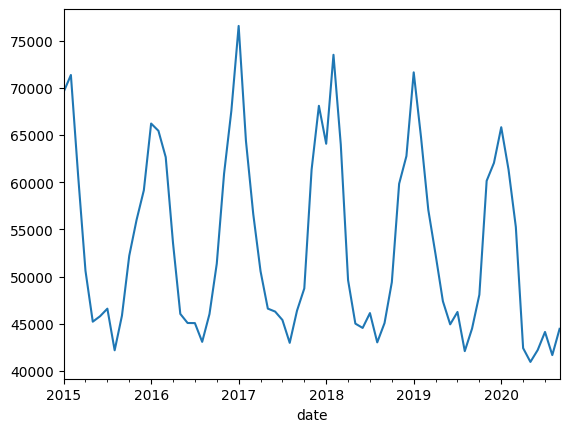

In [109]:
from matplotlib import pyplot
series = time_series['FR_load_actual_entsoe_transparency']
resample = series.resample('M')
monthly_mean = resample.mean()
print(monthly_mean.head(13))
monthly_mean.plot()
pyplot.show()

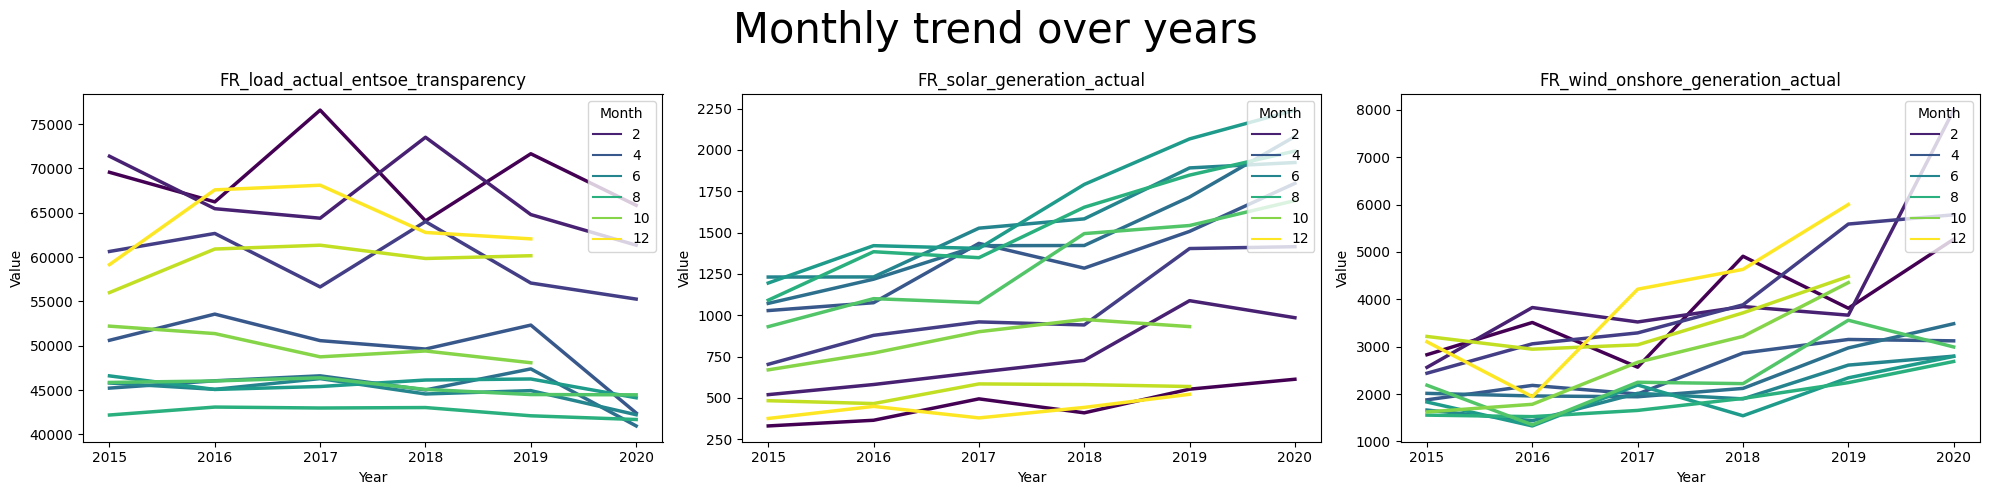

In [111]:
plot_seasonality(data = time_series, frequency='Year', hue='Month', title='Monthly trend over years')

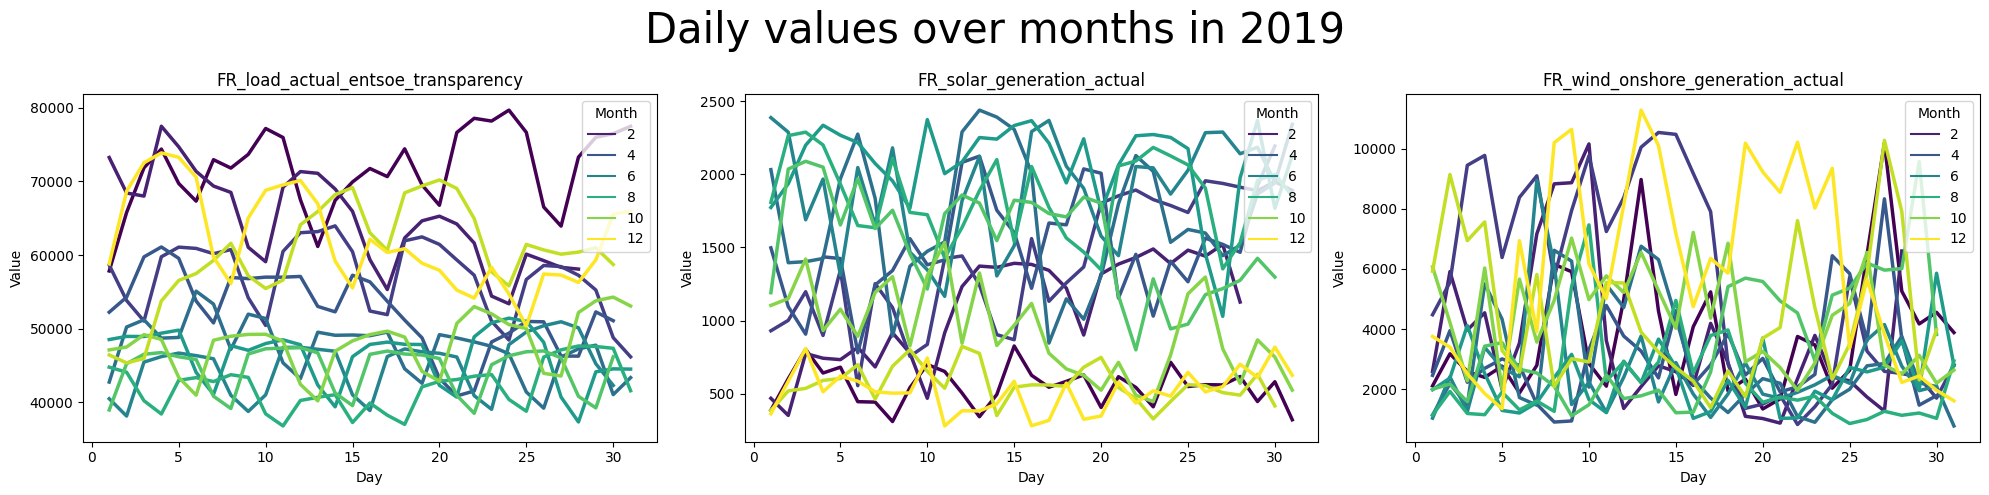

In [85]:
plot_seasonality(data = time_series[time_series.index.year == 2019], 
                 frequency='Day', 
                 hue='Month',
                 title = 'Daily values over months in 2019')

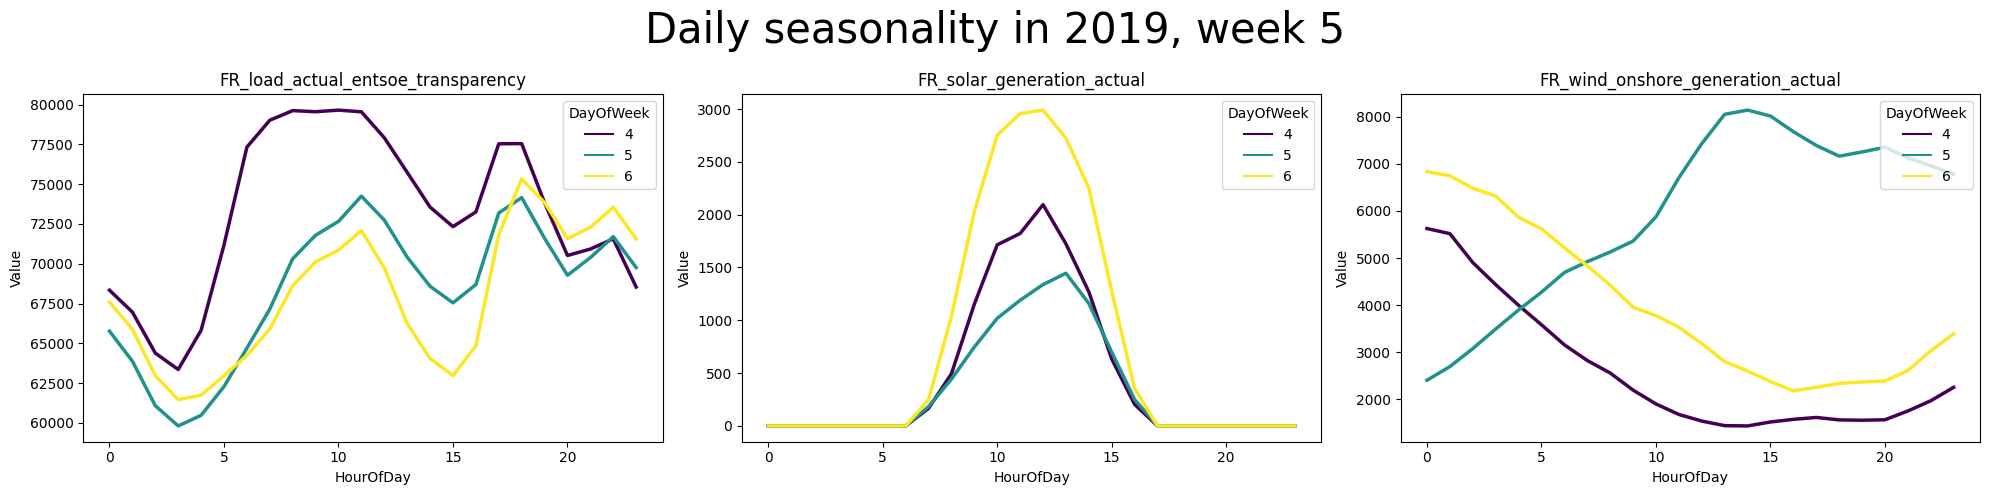

In [87]:
plot_seasonality(data=time_series[(time_series.index.year==2019) & 
                                  (time_series.index.month==2) & 
                                  (time_series.index.isocalendar().week==5)],
                 frequency='HourOfDay',
                 hue='DayOfWeek',
                 title = 'Daily seasonality in 2019, week 5')

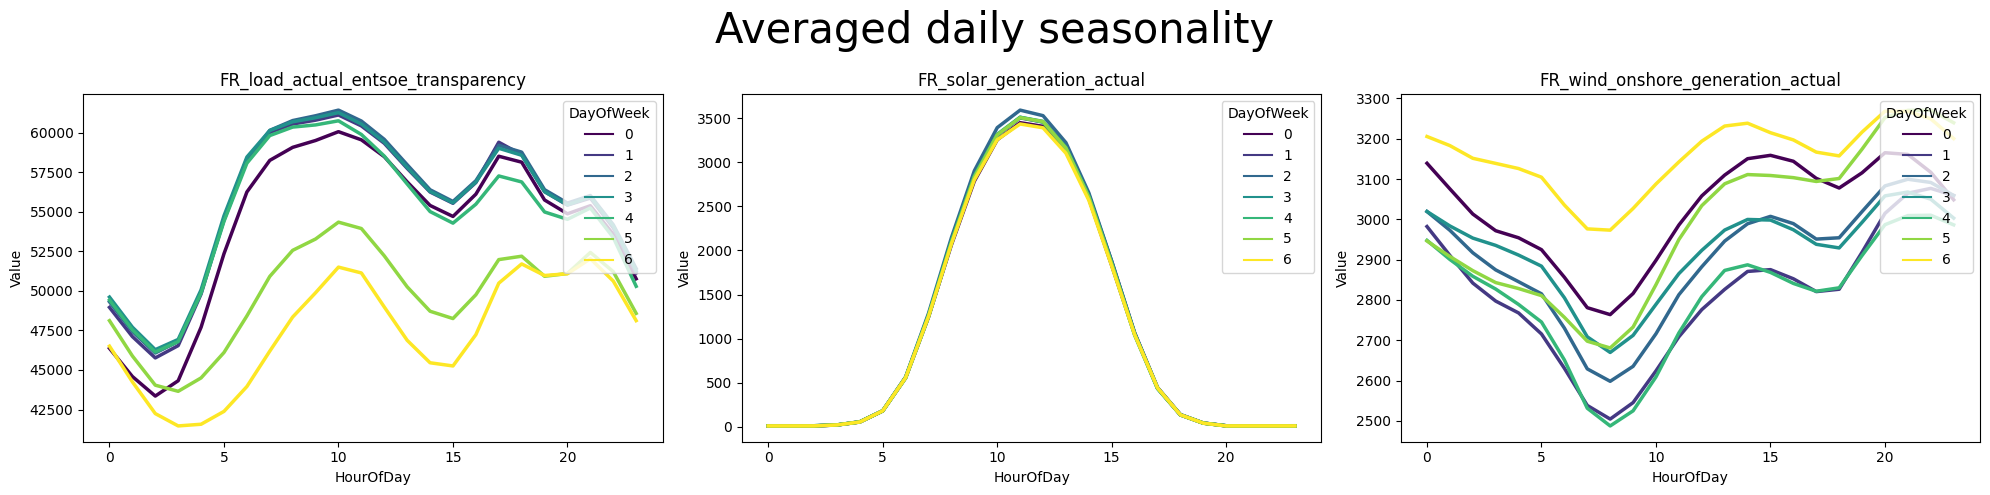

In [88]:
plot_seasonality(data=time_series,
                 frequency='HourOfDay',
                 hue='DayOfWeek',
                 title = 'Averaged daily seasonality')

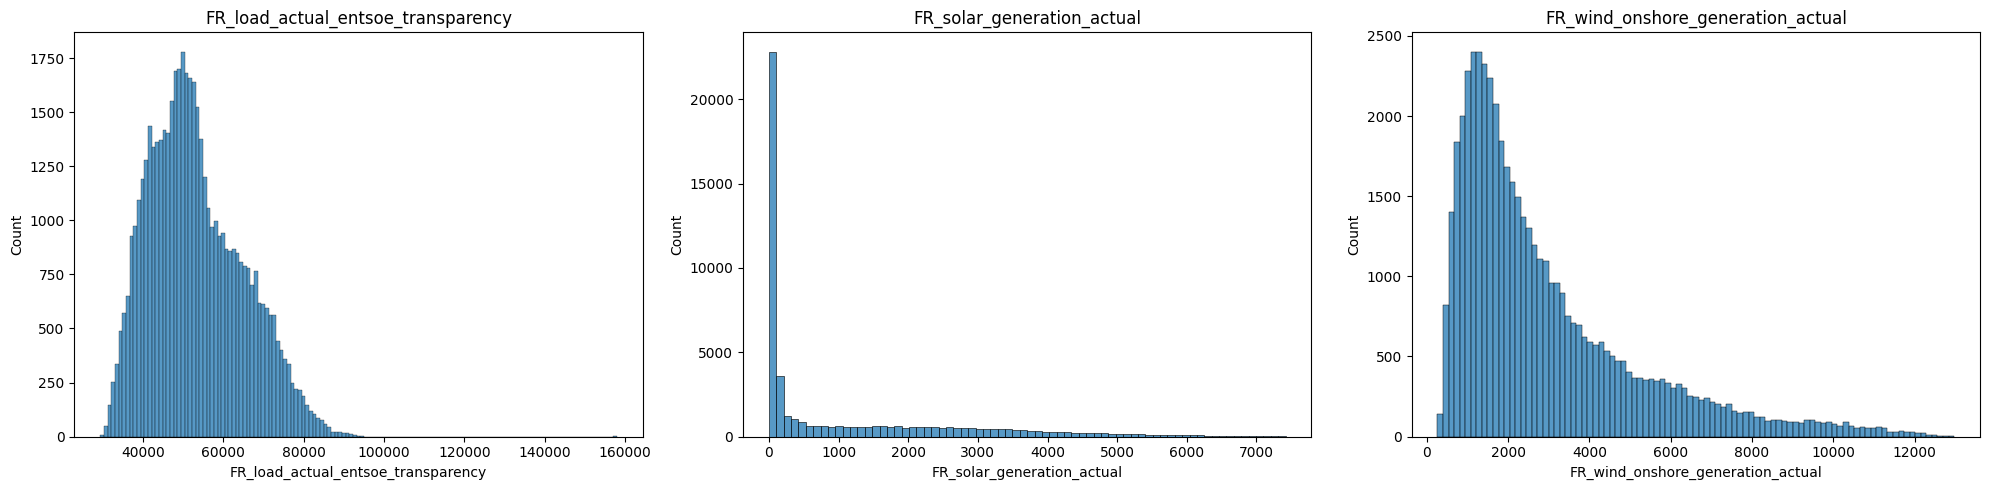

In [90]:
num_cols = 3
num_rows = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

for i, ax in enumerate(axes.flat):
    if i < len(time_series.columns):
        col = time_series.columns[i]
        sns.histplot(ax=ax, data=time_series, x=col)
        ax.set_title(f'{col}')
    else:
        ax.axis('off')   
plt.tight_layout()
plt.show()

In [115]:
24*24

576

In [114]:
24*7*3

504

In [116]:
time_series[-576:]

,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,Day,Year,Month,DayOfWeek,HourOfDay
date,,,,,,,,
2020-09-06 23:00:00,36597.0,139.0,1848.0,6,2020,9,6,23
2020-09-07 00:00:00,35203.0,136.0,1726.0,7,2020,9,0,0
2020-09-07 01:00:00,33312.0,136.0,1802.0,7,2020,9,0,1
2020-09-07 02:00:00,33072.0,135.0,1745.0,7,2020,9,0,2
2020-09-07 03:00:00,35403.0,135.0,1777.0,7,2020,9,0,3
...,...,...,...,...,...,...,...,...
2020-09-30 18:00:00,51975.0,140.0,3185.0,30,2020,9,2,18
2020-09-30 19:00:00,48210.0,142.0,3632.0,30,2020,9,2,19
2020-09-30 20:00:00,48210.0,142.0,3965.0,30,2020,9,2,20


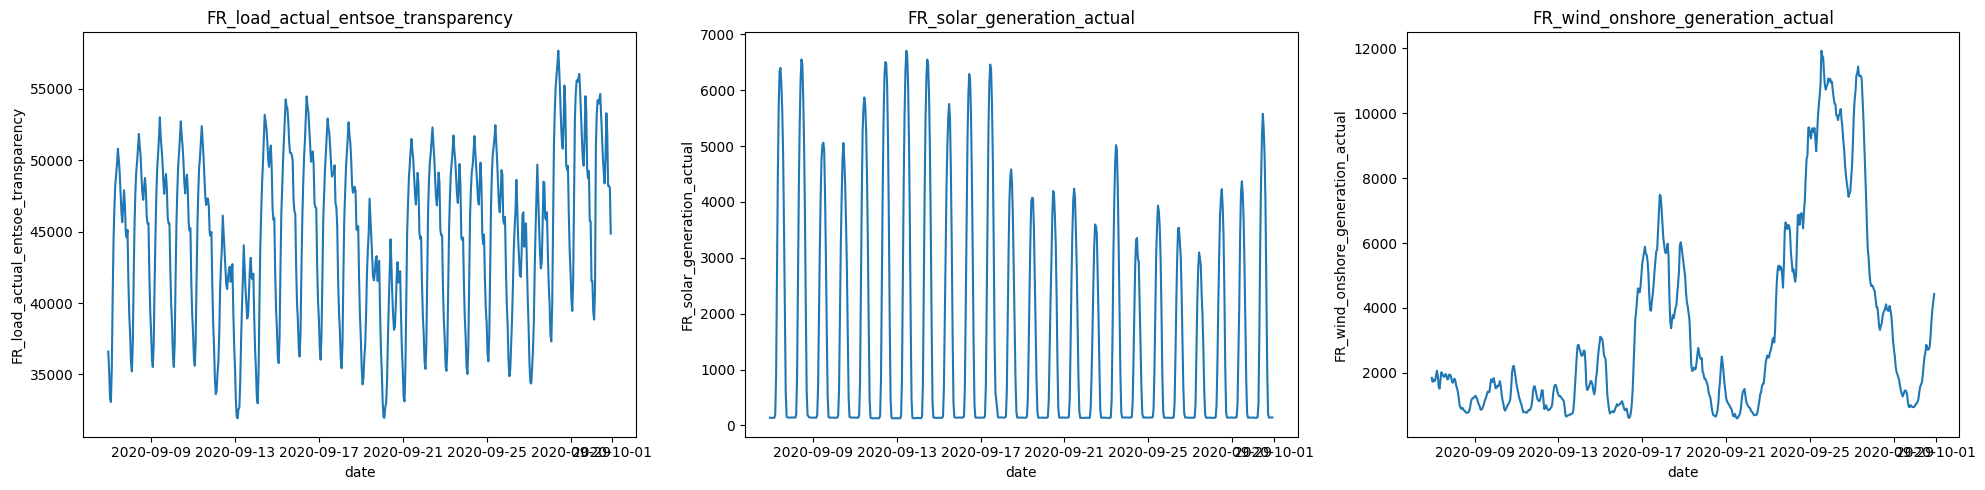

In [119]:
num_cols = 3
num_rows = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

for i, ax in enumerate(axes.flat):
    if i < len(time_series.columns):
        col = time_series.columns[i]
        sns.lineplot(ax=ax, data=time_series[-576:], x = time_series.index[-576:], y=col)
        ax.set_title(f'{col}')
    else:
        ax.axis('off')   
plt.tight_layout()
plt.show()

In [125]:
# 1 min 19 sec on the 1 col
adfuller(time_series['FR_load_actual_entsoe_transparency'])


(-7.7877866697578435,
 8.092421949967306e-12,
 57,
 50333,
 {'1%': -3.4304799273544244,
  '5%': -2.8615974252306753,
  '10%': -2.566800565549606},
 850221.1296699877)

In [130]:
# H0: Non-Stationarity exists in the series. (unit-root)

# H1: Stationarity exists in the series

# Second data point (P-Value): 0.35684591783869046: 
# Probability that null hypothesis will not be rejected(p-value)
# A small p-value (typically less than 0.05) indicates strong 
# evidence against the null hypothesis, supporting the conclusion that the time series is stationary.
# Also p-value of 0.35>0.05(if we take 5% significance level or 95% confidence interval), null hypothesis
# cannot be rejected. Hence data is non stationary (that means it has relation with time)

from statsmodels.tsa.stattools import adfuller

# Initialize a dictionary to store stationarity information for each column
stationarity_dict = {'Column': [], 'Is Stationary': []}

for column in time_series.columns[:3]:
    # Check stationarity using the ADF test
    adf_test = adfuller(time_series[column])
    is_stationary = adf_test[1] <= 0.05
    stationarity_dict['Column'].append(column)
    stationarity_dict['Is Stationary'].append(is_stationary)

# Create a DataFrame from the dictionary
stationarity_df = pd.DataFrame(stationarity_dict)

print("Stationarity Check Results:")
print(stationarity_df)

Stationarity Check Results:
                               Column  Is Stationary
0  FR_load_actual_entsoe_transparency           True
1          FR_solar_generation_actual           True
2   FR_wind_onshore_generation_actual           True


In [134]:
import statsmodels.api as sm

# Perform seasonal unit root test with seasonal differencing
y_diff = time_series.diff(24).dropna()  # Seasonal differencing (e.g., for monthly data)
result = sm.tsa.adfuller(y_diff['FR_load_actual_entsoe_transparency'], regression='c', autolag='AIC')

In [136]:
result[1] < 0.05

True

In [146]:
result_kpss = sm.tsa.stattools.kpss(time_series['FR_load_actual_entsoe_transparency'], regression='c')

/var/folders/wd/nrqjtvlj6gdc6x_gdm4wxjwr0000gn/T/ipykernel_51391/3039251064.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = sm.tsa.stattools.kpss(time_series['FR_load_actual_entsoe_transparency'], regression='c')


In [148]:
# there is strong evidence against the null hypothesis of stationarity.
result_kpss[1] <=0.01 # NON-STATIONARY?

True

<Axes: xlabel='date', ylabel='FR_load_actual_entsoe_transparency'>

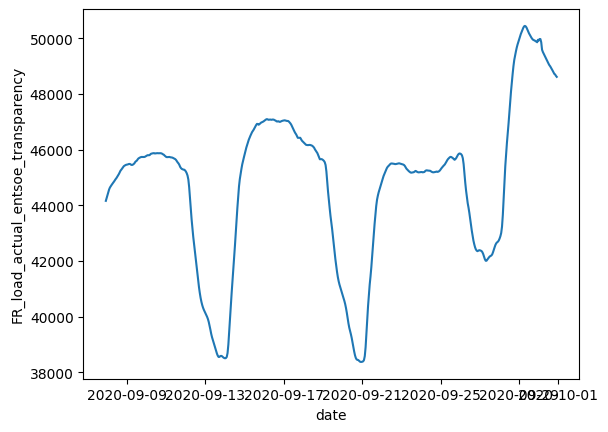

In [126]:
avgd_load = time_series[-576:]['FR_load_actual_entsoe_transparency'].rolling(24).mean()
sns.lineplot(avgd_load)

In [ ]:
sns.lineplot(data = time_series[-576:], x = time_series.index[-576:], y = 'FR_load_actual_entsoe_transparency')

# Load - weekly and daily seasonality (repeating pattern: low at night, peaks at )

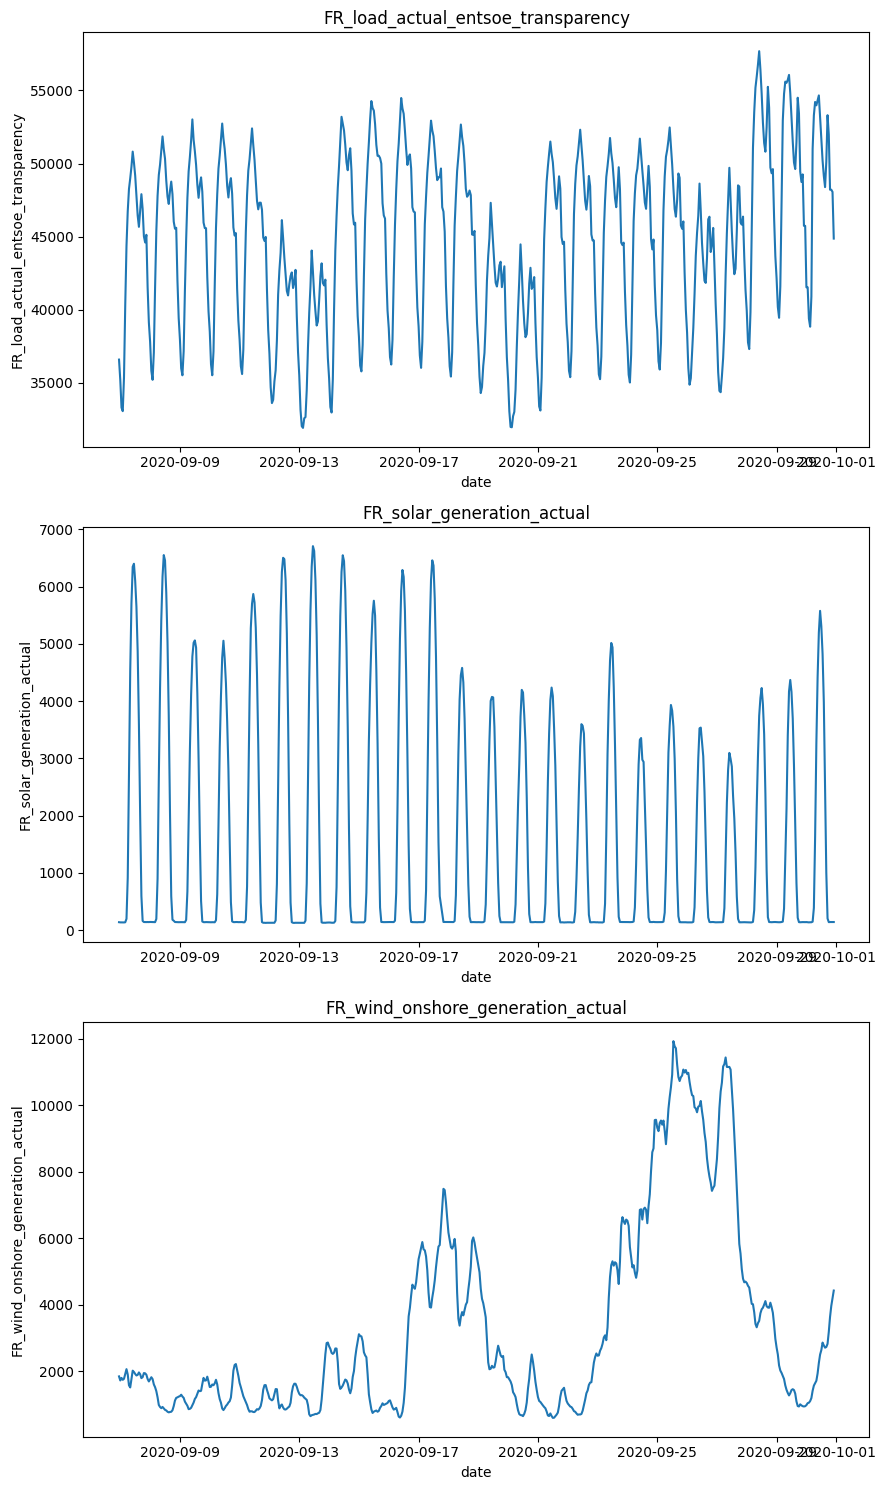

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'time_series' is your DataFrame with a DateTimeIndex

# Define the number of rows and columns
num_cols = 1
num_rows = 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 5 * num_rows))

# Loop over each subplot
for i, ax in enumerate(axes.flat):
    # Calculate the column index based on the subplot index
    col_index = i % len(time_series.columns)
    
    # Extract the column name
    col = time_series.columns[col_index]
    
    # Plot the data for the corresponding column
    sns.lineplot(ax=ax, data=time_series[-576:], x=time_series.index[-576:], y=col)
    
    # Set title for the subplot
    ax.set_title(f'{col}')
    
# Adjust layout
plt.tight_layout()
plt.show()


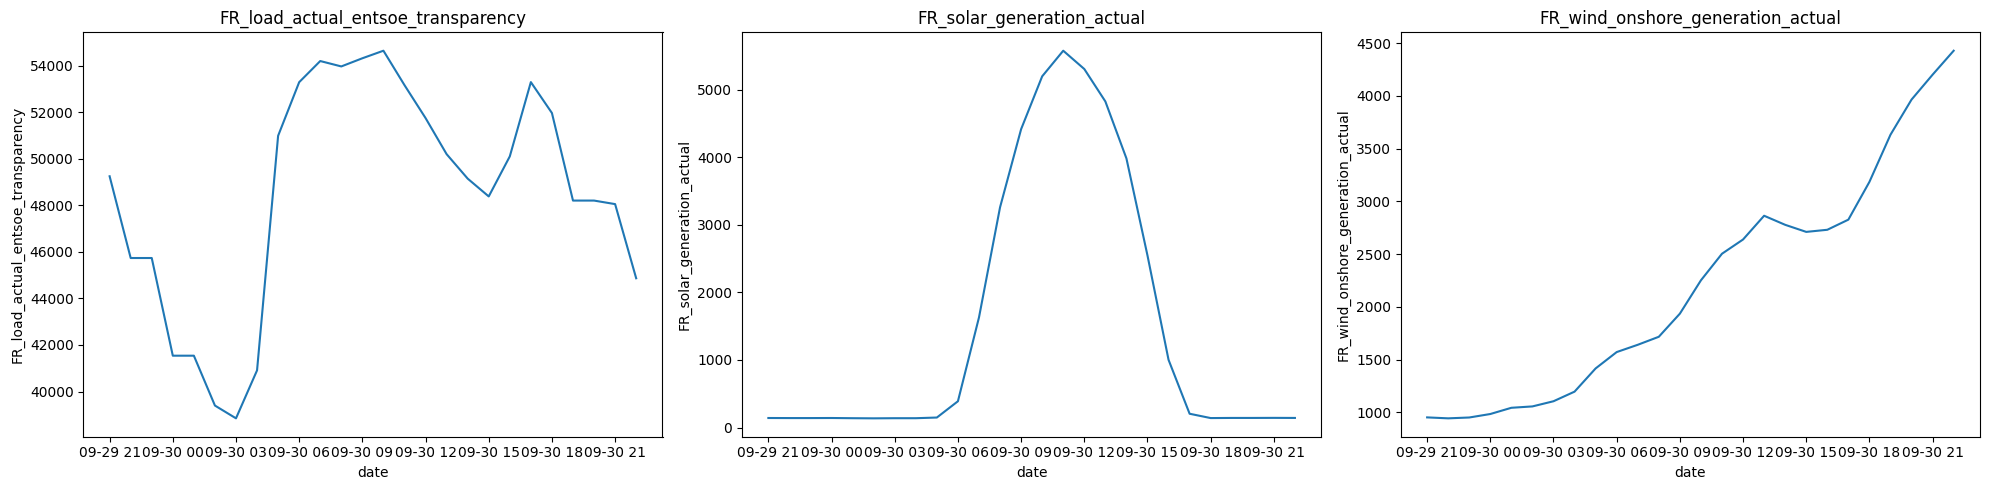

In [129]:
num_cols = 3
num_rows = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

for i, ax in enumerate(axes.flat):
    if i < len(time_series.columns):
        col = time_series.columns[i]
        sns.lineplot(ax=ax, data=time_series[-26:], x = time_series.index[-26:], y=col)
        ax.set_title(f'{col}')
    else:
        ax.axis('off')   
plt.tight_layout()
plt.show()

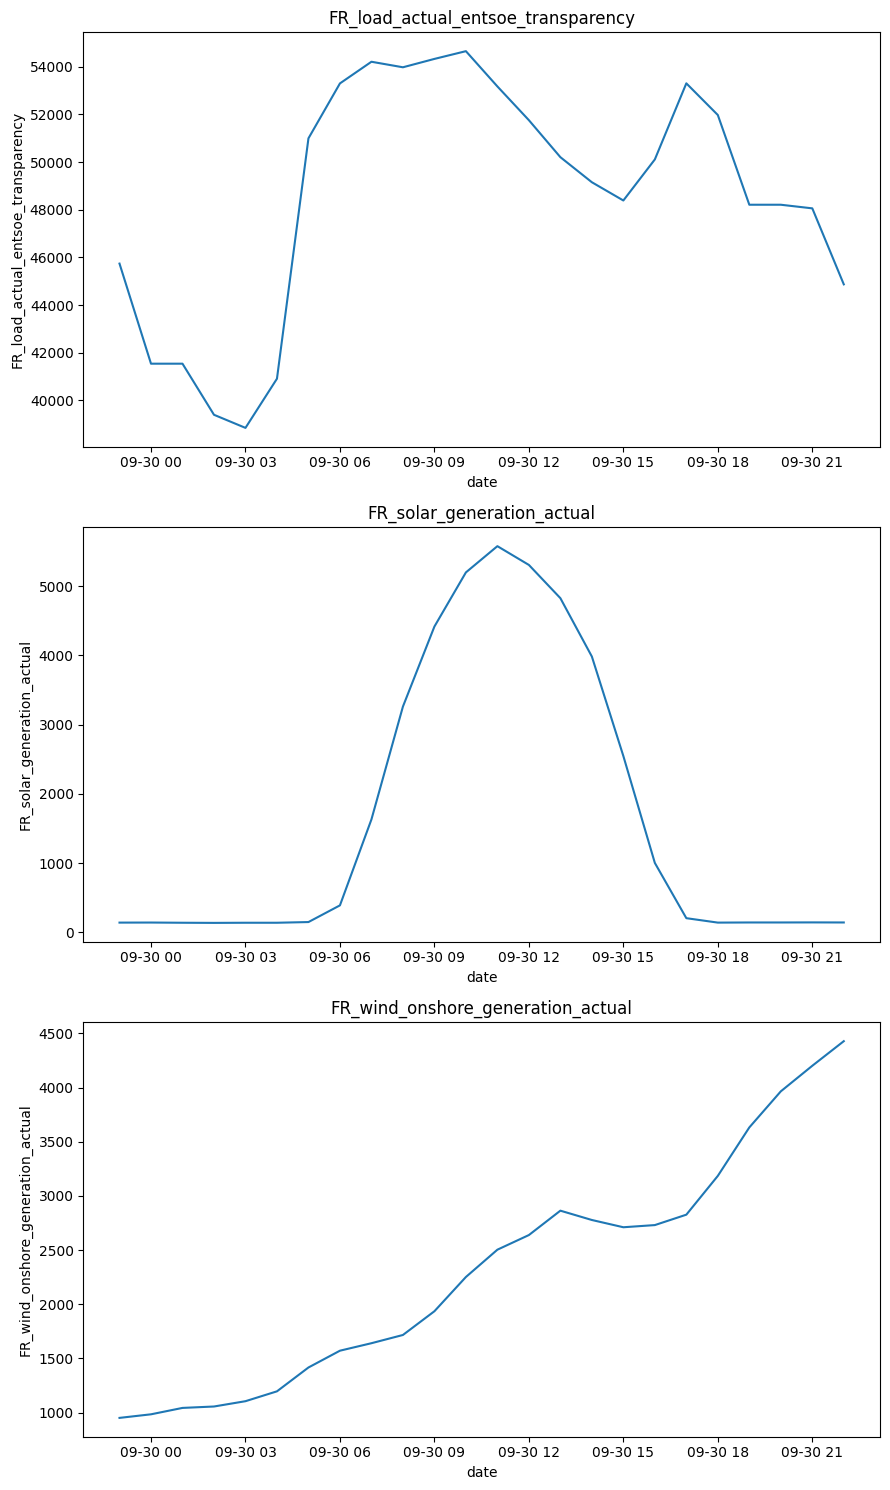

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'time_series' is your DataFrame with a DateTimeIndex

# Define the number of rows and columns
num_cols = 1
num_rows = 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 5 * num_rows))

# Loop over each subplot
for i, ax in enumerate(axes.flat):
    # Calculate the column index based on the subplot index
    col_index = i % len(time_series.columns)
    
    # Extract the column name
    col = time_series.columns[col_index]
    
    # Plot the data for the corresponding column
    sns.lineplot(ax=ax, data=time_series[-24:], x=time_series.index[-24:], y=col)
    
    # Set title for the subplot
    ax.set_title(f'{col}')
    
# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
"""
Plot trendlines
"""

fig, axes = plt.subplots(3, 1, figsize=(20, 6*26))#, sharey=True) # create a size and define the number + positions for subplots on the window

for i in range(26):
    for j, column in enumerate(list(cols[i])):
        # Note: index must be pd.DatetimeIndex! (otherwise it will create a value on x-axis 
        # for each separate observation)
        sns.lineplot(ax=axes[i, j], data = filtered_data, x=filtered_data.index, y=filtered_data[column])
        axes[i, j].set_title(column)  # Set subplot title
        axes[i, j].set_ylim(filtered_data[column].min(), filtered_data[column].max())
    
plt.tight_layout()
plt.show()


In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


data_dir = Path("../input/ts-course-data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

In [ ]:
import statsmodels.api as sm
# Iterate through each column and plot ACF and PACF
for column_name in df.columns:
    # Plot autocorrelation function (ACF)
    plt.figure(figsize=(12, 4))
    plot_acf(df[column_name], lags=168, title=f'Autocorrelation Function for {column_name}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.show()

    # Plot partial autocorrelation function (PACF)
    plt.figure(figsize=(12, 4))
    plot_pacf(df[column_name], lags=40, title=f'Partial Autocorrelation Function for {column_name}')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.grid(True)
    plt.show()

# Clear yearly and daily seasonality

In [155]:
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs, nsdiffs

In [ ]:
for col in time_series.columns[:3]:
    adf_test = ADFTest(alpha=0.05)
    p_value, should_diff = adf_test.should_diff(time_series[col])
    print(f"p-value: {p_value}, should_diff: {should_diff}")
    


In [149]:
adf_test = ADFTest(alpha=0.05)
p_value, should_diff = adf_test.should_diff(time_series["FR_load_actual_entsoe_transparency"])
is_stationary = adf_test.is_stationary(time_series["FR_load_actual_entsoe_transparency"])
# ndiffs(target_array, test='adf')

/var/folders/wd/nrqjtvlj6gdc6x_gdm4wxjwr0000gn/T/ipykernel_51391/2770393331.py:3: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  is_stationary = adf_test.is_stationary(time_series["FR_load_actual_entsoe_transparency"])


In [ ]:
def stationary_seasonal(time_series, column_name):

    adf_diff = ndiffs(time_series["FR_load_actual_entsoe_transparency"], test='adf')
    kpss_diff = ndiffs(time_series["FR_load_actual_entsoe_transparency"], test='kpss')
    pp_diff = ndiffs(time_series["FR_load_actual_entsoe_transparency"], test='pp')
    ocsb_diff = nsdiffs(time_series["FR_load_actual_entsoe_transparency"], test='ocsb', m=24)
    ch_diff = nsdiffs(time_series["FR_load_actual_entsoe_transparency"], test='ch', m=24)

    if adf_diff == 0 and kpss_diff == 0 and pp_diff == 0:
         print(f'{column_name} is stationary')
    else: 
        print(f'{column_name} is not stationary')

    if ocsb_diff == 0 and ch_diff == 0:
         print(f'{column_name} does not require seasonal differencing')
    else:
        print(f'{column_name} requires seasonal differencing')

In [151]:
p_value, should_diff

(0.01, False)

In [157]:
# IT RUNS 10 MINUTES ON 1 COLUMN!!!
adf_diff = ndiffs(time_series["FR_load_actual_entsoe_transparency"], test='adf')
kpss_diff = ndiffs(time_series["FR_load_actual_entsoe_transparency"], test='kpss')
pp_diff = ndiffs(time_series["FR_load_actual_entsoe_transparency"], test='pp')
ocsb_diff = nsdiffs(time_series["FR_load_actual_entsoe_transparency"], test='ocsb', m=24)
ch_diff = nsdiffs(time_series["FR_load_actual_entsoe_transparency"], test='ch', m=24)

In [158]:
adf_diff, kpss_diff, pp_diff, ocsb_diff, ch_diff

(0, 1, 0, 0, 1)

In [ ]:
# IT RUNS 10 MINUTES ON 1 COLUMN!!!
adf_diff = ndiffs(time_series["FR_solar_generation_entsoe_transparency"], test='adf')
kpss_diff = ndiffs(time_series["FR_load_actual_entsoe_transparency"], test='kpss')
pp_diff = ndiffs(time_series["FR_load_actual_entsoe_transparency"], test='pp')
ocsb_diff = nsdiffs(time_series["FR_load_actual_entsoe_transparency"], test='ocsb', m=24)
ch_diff = nsdiffs(time_series["FR_load_actual_entsoe_transparency"], test='ch', m=24)

In [163]:
train_ts = time_series[-600:-24]
test_ts = time_series[-24:]

# With m=24

In [165]:
# The period for seasonal differencing, m refers to the number of periods in each season.
# For example, m is 4 for quarterly data, 12 for monthly data, or 1 for annual (non-seasonal) data. 
# Default is 1. Note that if m == 1 (i.e., is non-seasonal), seasonal will be set to False. For more 
#information on setting this parameter, see Setting m.


model = auto_arima(train_ts.iloc[:,0], stepwise=True, seasonal=True, m=24, maxiter=3)
# model = pm.auto_arima(combined_data, seasonal=False, stepwise=True, trace=False, suppress_warnings=True)
# Make a forecast for the current window
#forecast, conf_int = model.predict(n_periods=prediction_length, return_conf_int=True)
            

In [191]:
model.params

<bound method ARIMA.params of ARIMA(maxiter=3, order=(5, 0, 0), scoring_args={}, seasonal_order=(0, 0, 2, 24),
      suppress_warnings=True)>

In [ ]:
updated_model = model.update(test_ts.iloc[:,0])

# Step 3: Forecast
forecast = updated_model.predict(n_periods=24)


In [192]:
model2.params

<bound method ARIMA.params of ARIMA(maxiter=3, order=(2, 0, 4), scoring_args={}, suppress_warnings=True)>

In [166]:
forecasts, confidence = model.predict(test_ts.shape[0], return_conf_int=True)  # predict N steps into the future

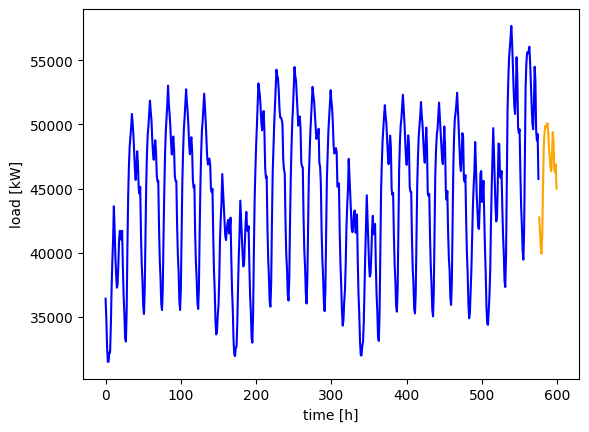

In [171]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(train_ts.shape[0] + test_ts.shape[0])
plt.plot(x[:train_ts.shape[0]], np.array(train_ts.iloc[:, 0]), c='blue')
plt.plot(x[train_ts.shape[0]:], forecasts, c='orange')
plt.xlabel("time [h]")
plt.ylabel("load [kW]")
plt.show()

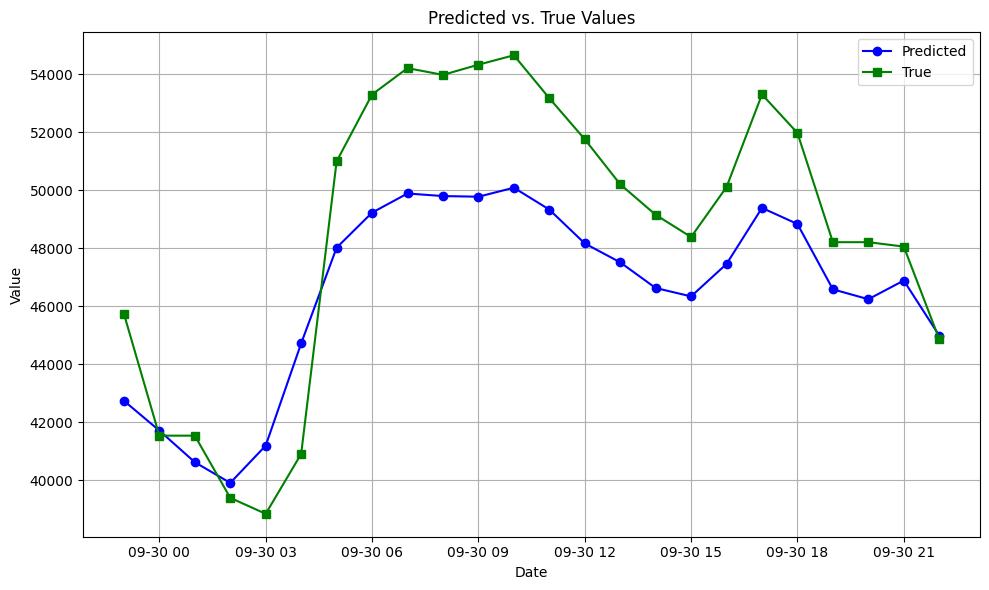

In [183]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(forecasts.index, forecasts, label='Predicted', color='blue', marker='o')  # Plot forecasted values
plt.plot(test_ts.index, test_ts.iloc[:, 0], label='True', color='green', marker='s')  # Plot true values
plt.xlabel('Date')  # Set x-axis label
plt.ylabel('Value')  # Set y-axis label
plt.title('Predicted vs. True Values')  # Set plot title
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()  # Display plot

In [176]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.sqrt(mean_squared_error(forecasts, test_ts.iloc[:, 0]))

3019.639899294806

In [177]:
mean_squared_error(forecasts, test_ts.iloc[:, 0])

9118225.121413147

In [182]:
df = pd.concat([test_ts.iloc[:, 0], forecasts], axis=1)
df.columns = ['Y_true', 'predicted'] 
df

,Y_true,predicted
2020-09-29 23:00:00,45740.0,42742.864115
2020-09-30 00:00:00,41540.0,41714.253527
2020-09-30 01:00:00,41540.0,40623.920446
2020-09-30 02:00:00,39396.0,39911.586563
2020-09-30 03:00:00,38846.0,41196.632844
2020-09-30 04:00:00,40910.0,44720.466419
2020-09-30 05:00:00,50996.0,48019.339309
2020-09-30 06:00:00,53301.0,49228.363408
2020-09-30 07:00:00,54210.0,49888.553852
2020-09-30 08:00:00,53978.0,49799.933336


# Seasonal=False

In [184]:
# 2.1 sec??????
model2 = auto_arima(train_ts.iloc[:,0], stepwise=True, seasonal=False, maxiter=3)

forecasts2, confidence2 = model2.predict(test_ts.shape[0], return_conf_int=True)  # predict N steps into the future


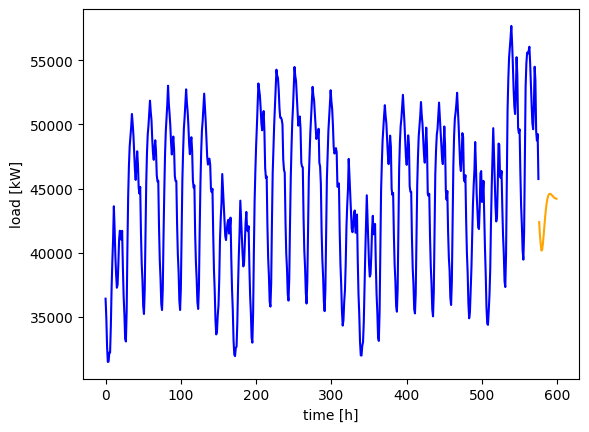

In [186]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(train_ts.shape[0] + test_ts.shape[0])
plt.plot(x[:train_ts.shape[0]], np.array(train_ts.iloc[:, 0]), c='blue')
plt.plot(x[train_ts.shape[0]:], forecasts2, c='orange')
plt.xlabel("time [h]")
plt.ylabel("load [kW]")
plt.show()

In [189]:
np.sqrt(mean_squared_error(forecasts2, test_ts.iloc[:, 0]))

6780.192668328311

In [190]:
df = pd.concat([test_ts.iloc[:, 0], forecasts2], axis=1)
df.columns = ['Y_true', 'predicted'] 
df

,Y_true,predicted
2020-09-29 23:00:00,45740.0,42384.640177
2020-09-30 00:00:00,41540.0,41378.206071
2020-09-30 01:00:00,41540.0,40703.875271
2020-09-30 02:00:00,39396.0,40158.492307
2020-09-30 03:00:00,38846.0,40237.694983
2020-09-30 04:00:00,40910.0,40709.681417
2020-09-30 05:00:00,50996.0,41384.073128
2020-09-30 06:00:00,53301.0,42117.210937
2020-09-30 07:00:00,54210.0,42810.620243
2020-09-30 08:00:00,53978.0,43405.251377
